### Research Paper Title Generation

In [1]:
pip install transformers datasets peft accelerate bitsandbytes


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\DELL\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### import libraries

In [2]:
import pandas as pd
import torch
from datasets import Dataset
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from peft import get_peft_model, LoraConfig, TaskType
from torch.utils.data import Dataset as TorchDataset
from sklearn.model_selection import train_test_split


### Upload dataset

In [3]:
import os

file_path = input("Enter the path to your file: ").strip().strip('"')
if os.path.exists(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.read()
        print("✅ File content loaded!")
else:
    print("❌ File not found. Please check the path.")


✅ File content loaded!


### Load dataset

In [4]:
import pandas as pd

# Replace with your uploaded file's path
file_path = r"C:\Users\DELL\Downloads\archive (4)\arXiv_scientific dataset.csv"

# Load the dataset
df = pd.read_csv(file_path)
print("✅ Dataset loaded successfully!")
print(df)


✅ Dataset loaded successfully!
                      id                                              title  \
0           cs-9308101v1                               Dynamic Backtracking   
1           cs-9308102v1  A Market-Oriented Programming Environment and ...   
2           cs-9309101v1            An Empirical Analysis of Search in GSAT   
3           cs-9311101v1  The Difficulties of Learning Logic Programs wi...   
4           cs-9311102v1  Software Agents: Completing Patterns and Const...   
...                  ...                                                ...   
136233  abs-2408.08541v1         Where is the signal in tokenization space?   
136234  abs-2408.08564v1  Collaborative Cross-modal Fusion with Large La...   
136235  abs-2408.08624v1  RealMedQA: A pilot biomedical question answeri...   
136236  abs-2408.08648v1  Understanding Enthymemes in Argument Maps: Bri...   
136237  abs-2408.08651v2  Reasoning Beyond Bias: A Study on Counterfactu...   

                    

###  Rename columns and remove missing/duplicate rows

In [6]:
df = df.rename(columns={'summary': 'abstract', 'summary_word_count': 'abstract_count'})
df = df[['abstract', 'title']].dropna().drop_duplicates()
df

,abstract,title
0,Because of their occasional need to return to ...,Dynamic Backtracking
1,Market price systems constitute a well-underst...,A Market-Oriented Programming Environment and ...
2,We describe an extensive study of search in GS...,An Empirical Analysis of Search in GSAT
3,As real logic programmers normally use cut (!)...,The Difficulties of Learning Logic Programs wi...
4,To support the goal of allowing users to recor...,Software Agents: Completing Patterns and Const...
...,...,...
136233,Large Language Models (LLMs) are typically shi...,Where is the signal in tokenization space?
136234,Despite the success of conventional collaborat...,Collaborative Cross-modal Fusion with Large La...
136235,Clinical question answering systems have the p...,RealMedQA: A pilot biomedical question answeri...
136236,Argument mining is natural language processing...,Understanding Enthymemes in Argument Maps: Bri...


In [8]:
df = df.head(500)  
df

,abstract,title
0,Because of their occasional need to return to ...,Dynamic Backtracking
1,Market price systems constitute a well-underst...,A Market-Oriented Programming Environment and ...
2,We describe an extensive study of search in GS...,An Empirical Analysis of Search in GSAT
3,As real logic programmers normally use cut (!)...,The Difficulties of Learning Logic Programs wi...
4,To support the goal of allowing users to recor...,Software Agents: Completing Patterns and Const...
...,...,...
495,A fuzzy mnesor space is a semimodule over the ...,Fuzzy Mnesors
496,We apply proof-theoretic techniques in answer ...,An Application of Proof-Theory in Answer Set P...
497,We show that some common and important global ...,"Decompositions of All Different, Global Cardin..."
498,To model combinatorial decision problems invol...,Scenario-based Stochastic Constraint Programming


### Tokenize Using GPT-2 Tokenizer

In [10]:
from transformers import GPT2Tokenizer

# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # GPT2 doesn't use pad_token, so set eos_token as pad


### Preprocess and Tokenize Dataset

In [12]:
from transformers import GPT2Tokenizer

def preprocess_and_tokenize(df, tokenizer, max_length=512):
    tokenized_list = []
    for _, row in df.iterrows():
        abstract = row['abstract']
        title = row['title']

        prompt = f"### Scientific Abstract:\n{abstract}\n### Predicted Title:"
        full_input = f"{prompt} {title}"

        encoding = tokenizer(
            full_input,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors="pt"
        )

        input_ids = encoding["input_ids"]
        labels = input_ids.clone()

        # Ignore loss for the prompt part
        prompt_ids = tokenizer(prompt, return_tensors="pt")["input_ids"][0]
        prompt_len = len(prompt_ids)
        labels[0, :prompt_len] = -100
        encoding["labels"] = labels

        tokenized_list.append(encoding)

    return tokenized_list



In [13]:
# Tokenizing the dataset
tokenized_inputs = preprocess_and_tokenize(df, tokenizer)

In [14]:
# Dataset for training
from torch.utils.data import Dataset as TorchDataset

class TitleDataset(TorchDataset):
    def __init__(self, tokenized_list):
        self.tokenized_list = tokenized_list

    def __len__(self):
        return len(self.tokenized_list)

    def __getitem__(self, idx):
        return {key: val.squeeze() for key, val in self.tokenized_list[idx].items()}

train_dataset = TitleDataset(tokenized_inputs)

### Load GPT-2 Model and Apply LoRA

In [15]:
# Load GPT-2 with LoRA
from transformers import GPT2LMHeadModel
from peft import get_peft_model, LoraConfig, TaskType

model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

# Better LoRA coverage
lora_config = LoraConfig(
    r=4,
    lora_alpha=32,
    target_modules=["c_attn", "mlp.c_fc", "mlp.c_proj", "attn.c_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, lora_config)

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\peft\tuners\lora\layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


-LoRA adds trainable adapters to GPT-2

-Efficient fine-tuning without changing all model weights

💡 LoRA Solution: Fine-tune Efficiently LoRA stands for Low-Rank Adaptation of Large Language Models. It freezes the original model weights and adds a few small trainable matrices that:

-Learn task-specific knowledge.

-Significantly reduce the number of trainable parameters.

### Training Configuration & Trainer

In [16]:
# Trainer setup
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
import os
import torch

os.environ["WANDB_DISABLED"] = "true"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_args = TrainingArguments(
    output_dir="./gpt2_lora_title_model",
    per_device_train_batch_size=4,
    num_train_epochs=3,
    warmup_steps=100,
    weight_decay=0.01,
    save_steps=500,
    logging_steps=1,
    save_total_limit=1,
    fp16=torch.cuda.is_available(),
    report_to=None
)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
C:\Users\DELL\AppData\Local\Temp\ipykernel_11320\2408475910.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
1,4.148700
2,3.902600
3,4.037400
4,4.765800
5,4.123900
6,3.912800
7,3.932900
8,4.338100
9,4.159400
10,4.163700


TrainOutput(global_step=375, training_loss=3.666485568364461, metrics={'train_runtime': 5338.1499, 'train_samples_per_second': 0.281, 'train_steps_per_second': 0.07, 'total_flos': 394655956992000.0, 'train_loss': 3.666485568364461, 'epoch': 3.0})

### Save the Model

In [17]:
# Save the model and tokenizer
model.save_pretrained(r"D:\nlp project\gpt2_lora_title_model")
tokenizer.save_pretrained(r"D:\nlp project\gpt2_lora_title_model")



('D:\\nlp project\\gpt2_lora_title_model\\tokenizer_config.json',
 'D:\\nlp project\\gpt2_lora_title_model\\special_tokens_map.json',
 'D:\\nlp project\\gpt2_lora_title_model\\vocab.json',
 'D:\\nlp project\\gpt2_lora_title_model\\merges.txt',
 'D:\\nlp project\\gpt2_lora_title_model\\added_tokens.json')

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import pandas as pd
import re
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

# Load model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained(r"D:\nlp project\gpt2_lora_title_model")
tokenizer = GPT2Tokenizer.from_pretrained(r"D:\nlp project\gpt2_lora_title_model")
model.to(device)



# Load SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to generate title
def generate_title_lora(abstract, model, tokenizer, device):
    model.eval()
    prompt = (
        "Given the following abstract, generate a concise academic paper title "
        "(no more than 12 words):\n\n"
        f"{abstract}\n\nTitle:"
    )

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=30,  # Increased for more complete outputs
            do_sample=False,
            num_beams=5,
            no_repeat_ngram_size=2,
            repetition_penalty=1.1,
            pad_token_id=tokenizer.eos_token_id
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    match = re.search(r"Title:\s*(.*)", decoded, re.IGNORECASE)
    if match:
        title = match.group(1).strip()
    else:
        title = decoded.strip()

    title = re.sub(r'[^\w\s-]', '', title).strip()
    title_tokens = title.split()
    if len(title_tokens) > 15:
        title = ' '.join(title_tokens[:15])

    return title

# Semantic similarity using SBERT
def semantic_similarity_sbert(title1, title2):
    embeddings = sbert_model.encode([title1, title2], convert_to_tensor=True)
    similarity = util.pytorch_cos_sim(embeddings[0], embeddings[1])
    return similarity.item()


* semantic_similarity_sbert measures **semantic similarity** (meaning) between two sentences.
* Sentence Bidirectional Encoder Representations from Transformers
* It compares the **meaning** of a **generated title** with a **true title**.
* Focuses on **meaningful similarity**, not just word overlap.
* Uses **sentence embeddings** and computes **cosine similarity**.


Score range: 0 (completely different) to 1 (identical in meaning)

0.0 – 0.3: Little to no semantic similarity

0.3 – 0.6: Somewhat similar, but not strongly aligned

0.6 – 0.8: Moderate to strong semantic similarity

0.8 – 1.0: Highly or near-identical meaning

In [22]:
results = []

for idx in range(6):
    abstract = df.iloc[idx]['abstract']
    original_title = df.iloc[idx]['title']
    generated_title = generate_title_lora(abstract, model, tokenizer, device)
    similarity = semantic_similarity_sbert(original_title, generated_title)

    print(f"\n📄 Index: {idx}")
    print(f"📝 Abstract: {abstract}")
    print(f"✅ Original Title: {original_title}")
    print(f"🎯 Generated Title: {generated_title}")
    print(f"🔍 Semantic Similarity Score: {similarity:.4f}")

    results.append({
        'Index': idx,
        'Original Title': original_title,
        'Generated Title': generated_title,
        'Similarity Score': similarity
    })



📄 Index: 0
📝 Abstract: Because of their occasional need to return to shallow points in a search
tree, existing backtracking methods can sometimes erase meaningful progress
toward solving a search problem. In this paper, we present a method by which
backtrack points can be moved deeper in the search space, thereby avoiding this
difficulty. The technique developed is a variant of dependency-directed
backtracking that uses only polynomial space while still providing useful
control information and retaining the completeness guarantees provided by
earlier approaches.
✅ Original Title: Dynamic Backtracking
🎯 Generated Title: A Dependent-Directed Backtracking Method for Searching Deep Points in Search Trees
🔍 Semantic Similarity Score: 0.5740

📄 Index: 1
📝 Abstract: Market price systems constitute a well-understood class of mechanisms that
under certain conditions provide effective decentralization of decision making
with minimal communication overhead. In a market-oriented programming appro

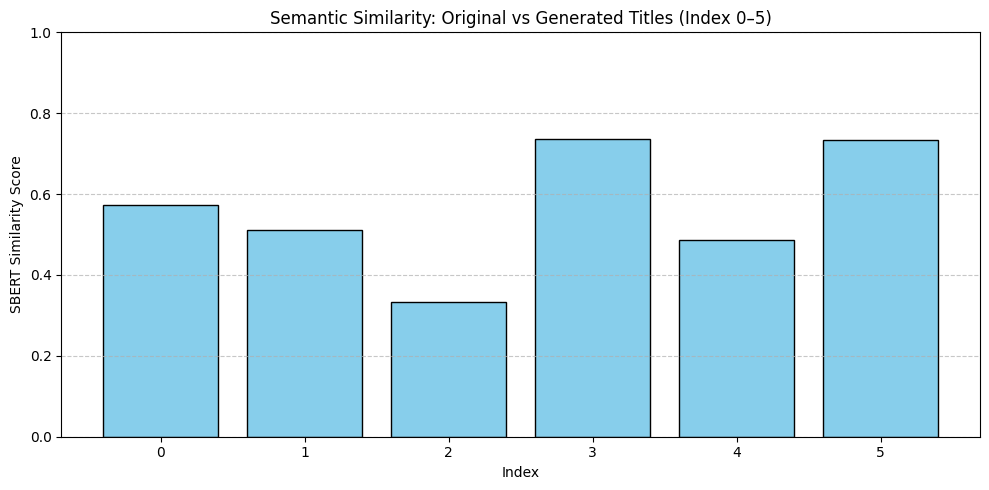

In [24]:
# Create DataFrame and plot bar graph
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 5))
plt.bar(results_df['Index'], results_df['Similarity Score'], color='skyblue', edgecolor='black')
plt.title('Semantic Similarity: Original vs Generated Titles (Index 0–5)')
plt.xlabel('Index')
plt.ylabel('SBERT Similarity Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(results_df['Index'])
plt.tight_layout()
plt.show()


| Step | Title                           | Summary                                                                       |
| ---- | ------------------------------- | ----------------------------------------------------------------------------- |
| 1    | **Install Libraries**           | Installs: `transformers`, `datasets`, `peft`, `accelerate`, `bitsandbytes`.   |
| 2    | **Import Libraries**            | Imports Pandas, PyTorch, Transformers (GPT-2), PEFT (for LoRA).               |
| 3    | **Upload Dataset**              | Uses `os` and direct file path to access the CSV dataset.                     |
| 4    | **Load Dataset**                | Reads the CSV file using `pandas.read_csv()`.                                 |
| 5    | **Clean Dataset**               | Renames the `summary` column to `abstract`, removes null or duplicate rows.   |
| 6    | **Tokenize Dataset**            | Loads the GPT-2 tokenizer with padding and truncation for abstracts.          |
| 7    | **Preprocess for Model Input**  | Converts the DataFrame into a HuggingFace `Dataset` and tokenizes it.         |
| 8    | **Load GPT-2 Model with LoRA**  | Loads the GPT-2 model and applies Low-Rank Adaptation (LoRA) for fine-tuning. |
| 9    | **Setup Training Arguments**    | Defines batch size, epochs, and logging strategy for training.                |
| 10   | **Train Model**                 | Uses the `Trainer` class to fine-tune GPT-2 on abstract → title mapping.      |
| 11   | **Generate Title for Abstract** | Loads the fine-tuned model and generates a title for a new abstract.          |
